In [3]:
import math
import csv
import numpy as np
import matplotlib.pyplot as plt
from math import e
import statistics as st
import cmath

# Reading S11 file

In [4]:
data = map(lambda x: [ x[0], x[1], x[2] ],
        np.loadtxt("/Users/gopipatel/Documents/RRI_VSP/saras3_S11_200mm_above_water.s1p", skiprows=5))
d=list(data) #List of the format [Frequency, Magnitude, Phase (in degrees)]


# Initialising Variables

In [5]:
c=3*10**8  # speed of light (m/s)

#frequency

v=[d[i][0] for i in range(len(d))]

#LNA Values

gamma_N=10**-(10 / 20)       #Reflection Coeff. at the LNA i/p (gamma N):10db
P_N= 70                      #Noise Power of the LNA in K 
phi_N=0                      #phase of the noise wave
f=0.1                        #Corr factor between the fwd and bkwd of the LNA, complex qty
phi_f=0                      #phase of the corr factor
P_ref=300                    #ambient temperature

#transmission line length

lmin=0.1                     #min length of the transmission line in m
lmax=1                       #max length of the transmission line in m

#values at the antenna end

#reflection coefficients
gamma_As=-1                 #Reflection Coeff. at the short terminal in db- Short
gamma_Ao=1                  #Reflection Coeff. at the open terminal in db - Open
gamma_Am=0                  #Reflection Coeff. at the 50 ohm terminal in db- Matched
gamma_Asky=[d[i][1] for i in range(len(v))]  #Reflection Coeff. of the antenna (frequency dependent), simulated S11 for SARAS3 baseline design

#power due to different terminals
P_s=0           #Power at the short terminal
P_o=0           #Power at the open terminal
P_m= 300        #Power at the 50ohm terminal

Po=200          #Kelvin
vo=150*1e6      #Hz
a=2.5           #spectral index
P_sky= [Po*(k/vo)**-a for k in v]      #Power at the antenna (sky) (frequency dependent)

#Phase
phi_As=np.pi         #Phase of the wave reflected at the short terminal
phi_Ao=0             #Phase of the wave reflected at the short terminal
phi_Am=0             #Phase of the wave reflected at the short terminal
phi_Asky= [math.radians(d[i][2]) for i in range(len(v))] #[cmath.phase(d[i][1]) for i in range(len(v))] 

#print(phi_Asky)#[0][1],math.radians(d[0][2]))

In [6]:
print(gamma_Asky)
cc=np.polyfit(v, gamma_Asky, 7)
fit = np.polyval(cc,v)
res = gamma_Asky-fit

[0.80604323, 0.79152927, 0.77690924, 0.76199026, 0.74683639, 0.73145239, 0.71594499, 0.70028963, 0.68459464, 0.66889475, 0.65322677, 0.6376209, 0.62212772, 0.60677785, 0.59160739, 0.57664457, 0.5619172, 0.54744888, 0.53325987, 0.51937948, 0.50580031, 0.49254763, 0.47963476, 0.46707392, 0.45486203, 0.44331042, 0.43182707, 0.42072057, 0.40997281, 0.39959368, 0.38960091, 0.37998057, 0.37073083, 0.36184046, 0.35334123, 0.34519601, 0.33741593, 0.33001616, 0.32296267, 0.31630349, 0.31001854, 0.30409717, 0.29856247, 0.29337155, 0.28858466, 0.28419277, 0.28017513, 0.27655826, 0.27333072, 0.27052077, 0.26761455, 0.26560834, 0.26405074, 0.26292049, 0.2622476, 0.26202895, 0.26228617, 0.26299512, 0.26419787, 0.26589418, 0.26808634, 0.27079005, 0.2739918, 0.27770944, 0.28193447, 0.28667299, 0.29193172, 0.29766634, 0.30387668, 0.31057974, 0.31771188]


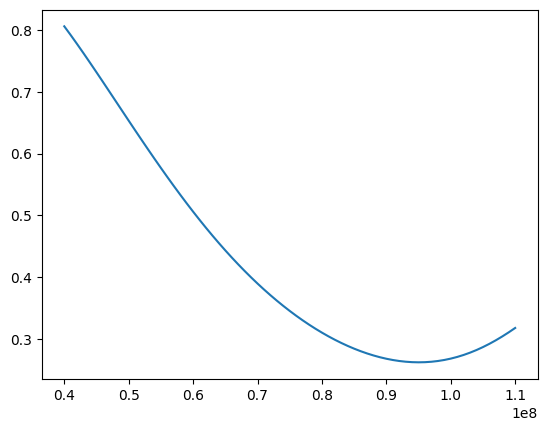

In [6]:
plt.figure()
plt.plot(v, fit)
plt.show()

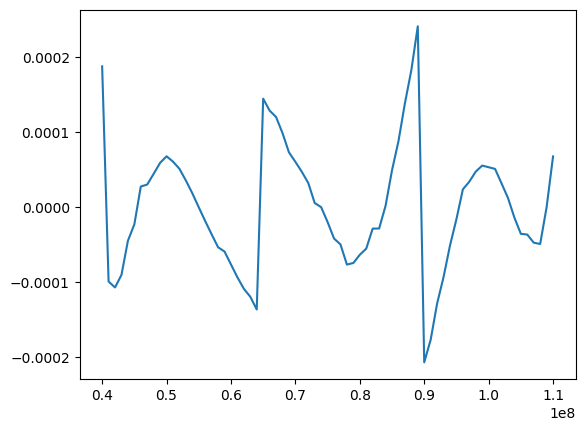

In [7]:
plt.figure()
plt.plot(v, res)
plt.show()

# Tmeas for higher order reflections for short, open, matched terminations and Sky model

In [8]:

def Compute_Tmeas_(type,freq,itr): 
    A=0
    B=0
    C=0
    if(type=="matched"):  # for 50ohm termination
        P_A=P_m
        gamma_A=gamma_Am
        phi_A=phi_Am
    elif(type=="short"):  # for short termination
        P_A=P_s
        gamma_A=gamma_As
        phi_A=phi_As
    elif(type=="open"): # for open termination
        P_A=P_o
        gamma_A=gamma_Ao
        phi_A=phi_Ao
    else: #sky
        i=v.index(freq)
        P_A=P_sky[i]
        gamma_A=gamma_Asky[i]
        phi_A=phi_Asky[i]

    phi= (4*math.pi*(freq)*lmin)/(0.7*c)
    A=sum((abs(gamma_A)**k)*(abs(gamma_N)**k)*sum(math.cos((2*l-k)*(phi_N+phi_A+phi))for l in range(k+1)) for k in range(itr))   
    
    B=sum(2*abs(f)*(abs(gamma_A)**(o+1))*(abs(gamma_N)**o)*math.cos(phi_f+(o+1)*(phi_A+phi)+a*phi_N) for o in range(itr))

    C=sum((abs(gamma_A)**b)*(abs(gamma_N)**b)*sum(math.cos((2*c-b)*(phi_N+phi_A+phi)) for c in range(b+1)) for b in range(itr))
    
    Tmeas=(P_A*A-P_ref)+P_N*(B+(abs(f)**2)*(abs(gamma_A)**2)*C)
    return(Tmeas)


## Plotting Tmeas vs Frequency

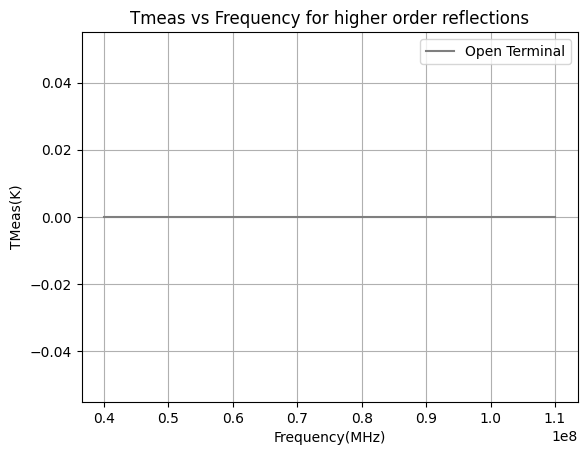

In [10]:
itr=6 #Number of high order reflections
s=[Compute_Tmeas_("short",freq=j,itr=itr) for j in v] #short
o=[Compute_Tmeas_("open",freq=j,itr=itr) for j in v] #open
m=[Compute_Tmeas_("matched",freq=j,itr=itr) for j in v] #matched
sky=[Compute_Tmeas_("sky",freq=j,itr=itr) for j in v] #sky

plt.plot(v,o,'tab:pink')
plt.plot(v,s,'tab:olive')
plt.plot(v,m,'tab:grey')
plt.plot(v,sky,'tab:blue')

plt.title("Tmeas vs Frequency for higher order reflections")
plt.legend(["Open Terminal", "Short Terminal","Matched Terminal","Sky"]) 
plt.xlabel("Frequency(MHz)")
plt.ylabel("TMeas(K)")
plt.grid()

# Estimating Antenna signal and LNA noise effects in eqn 49 separately 

In [10]:
#Antenna term
def plot_PA(type,freq,itr):
    
    if(type=="matched"):  #for 50ohm termination
        P_A=P_m
        gamma_A=gamma_Am
        phi_A=phi_Am
    elif(type=="short"):  #for short termination
        P_A=P_s
        gamma_A=gamma_As
        phi_A=phi_As
    elif(type=="open"):   #for open termination
        P_A=P_o
        gamma_A=gamma_Ao
        phi_A=phi_Ao
    else:                 #sky
        i=v.index(freq)
        P_A=P_sky[i]
        gamma_A=gamma_Asky[i]
        phi_A=phi_Asky[i]
        
    phi= (4*math.pi*(freq)*lmin)/(0.7*c)
    A=0
    
    A=sum((abs(gamma_A)**k)*(abs(gamma_N)**k)*sum(math.cos((2*l-k)*(phi_N+phi_A+phi))for l in range(k+1)) for k in range(itr)) 
    PA=P_A*A-P_ref
    return(PA)

#LNA Noise PN term
def plot_PN(type,freq,itr):
    
    if(type=="matched"):  #for 50ohm termination
        P_A=P_m
        gamma_A=gamma_Am
        phi_A=phi_Am
    elif(type=="short"):  #for short termination
        P_A=P_s
        gamma_A=gamma_As
        phi_A=phi_As
    elif(type=="open"):   #for open termination
        P_A=P_o
        gamma_A=gamma_Ao
        phi_A=phi_Ao
    else:                 #sky
        i=v.index(freq)
        P_sky= Po*(freq/vo)**-a 
        P_A=P_sky
        gamma_A=gamma_Asky[i]
        phi_A=phi_Asky[i]
        
    phi= (4*math.pi*(freq)*lmax)/(0.7*c)
    B=0
    C=0
    
    B=sum(2*abs(f)*(abs(gamma_A)**(o+1))*(abs(gamma_N)**o)*math.cos(phi_f+(o+1)*(phi_A+phi)+o*phi_N) for o in range(itr))
    C=sum((abs(gamma_A)**b)*(abs(gamma_N)**b)*sum(math.cos((2*c-b)*(phi_N+phi_A+phi)) for c in range(b+1)) for b in range(itr))

    PN=P_N*(B+(abs(f)**2)*(abs(gamma_A)**2)*C)
    return(PN)
    
    

## Plotting P_A-P_ref term and PN term wrt Frequency

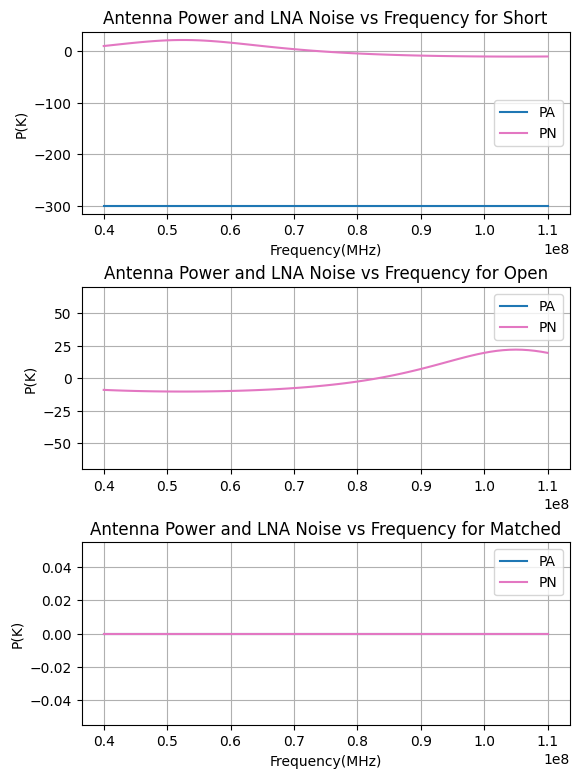

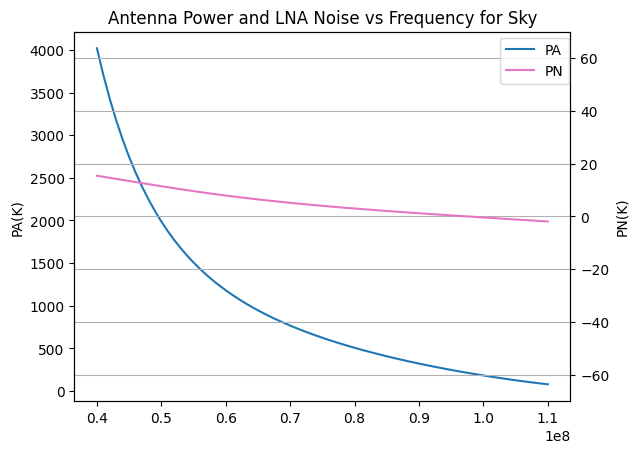

'\n#plt.subplot(2,2,4)\n#plt.plot(v,PA,\'b\')\nplt.plot(v,PN,\'tab:pink\')\nplt.legend(["PA", "PN"]) \nplt.title(\'Antenna Power and LNA Noise vs Frequency for Sky\')\nplt.xlabel("Frequency(MHz)")\nplt.ylabel("P(K)")\nplt.grid()\n'

In [23]:
#short
itr=7
PA=[plot_PA("short",freq=j,itr=itr) for j in v]
PN=[plot_PN("short",freq=j,itr=itr) for j in v]
plt.subplots(3,1, figsize=(6.3, 9))
plt.subplots_adjust(hspace=0.4, wspace=0.5)
plt.subplot(3,1,1)
plt.plot(v,PA,'tab:blue')
plt.plot(v,PN,'tab:pink')
plt.legend(["PA", "PN"]) 
plt.title('Antenna Power and LNA Noise vs Frequency for Short')
plt.xlabel("Frequency(MHz)")
plt.ylabel("P(K)")
plt.grid()

#open
PA=[plot_PA("open",freq=j,itr=itr) for j in v]
PN=[plot_PN("open",freq=j,itr=itr) for j in v]
plt.subplot(3,1,2)
plt.plot(v,PA,'tab:blue')
plt.plot(v,PN,'tab:pink')
plt.legend(["PA", "PN"]) 
plt.title('Antenna Power and LNA Noise vs Frequency for Open')
#plt.xlabel("Frequency(MHz)")
plt.ylim(-70,70)
plt.ylabel("P(K)")
plt.grid()

#matched
PA=[plot_PA("matched",freq=j,itr=itr) for j in v]
PN=[plot_PN("matched",freq=j,itr=itr) for j in v]
plt.subplot(3,1,3)
plt.plot(v,PA,'tab:blue')
plt.plot(v,PN,'tab:pink')
plt.legend(["PA", "PN"]) 
plt.title('Antenna Power and LNA Noise vs Frequency for Matched')
plt.xlabel("Frequency(MHz)")
plt.ylabel("P(K)")
plt.grid()

#sky

PA=[plot_PA("sky",freq=j,itr=itr) for j in v]
PN=[plot_PN("sky",freq=j,itr=itr) for j in v]
x = v
y1 = PA
y2 = PN
#plt.subplot(2,2,4)
fig, ax_left = plt.subplots()
ax_left.plot(x, y1, label='PA', color='tab:blue')
ax_left.set_ylabel('PA(K)')

ax_right = ax_left.twinx()
ax_right.plot(x, y2, label='PN', color='tab:pink')
ax_right.set_ylabel('PN(K)')
ax_right.set_ylim(-70,70)
ax_right.set_xlabel("Frequency(MHz)")


plt.title('Antenna Power and LNA Noise vs Frequency for Sky')
fig.legend(['PA','PN'],loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
plt.grid()
plt.show()

"""
#plt.subplot(2,2,4)
#plt.plot(v,PA,'b')
plt.plot(v,PN,'tab:pink')
plt.legend(["PA", "PN"]) 
plt.title('Antenna Power and LNA Noise vs Frequency for Sky')
plt.xlabel("Frequency(MHz)")
plt.ylabel("P(K)")
plt.grid()
"""

# Tmeas for no multiple reflections

In [12]:
def Compute_Tmeas(type,freq):
    Tmeas=0
    if(type=="matched"):  # for 50ohm termination
        P_A=P_m
        gamma_A=gamma_Am
        phi_A=phi_Am
    elif(type=="short"):  # for short termination
        P_A=P_s
        gamma_A=gamma_As
        phi_A=phi_As
    elif(type=="open"): # for open termination
        P_A=P_o
        gamma_A=gamma_Ao
        phi_A=phi_Ao
    else: #sky
        i=v.index(freq)
        P_sky= Po*(freq/vo)**-a 
        P_A=P_sky
        gamma_A=gamma_Asky[i]
        phi_A=phi_Asky[i]
        
    phi= (4*math.pi*(freq)*lmin)/(0.7*c)   
    Tmeas=(P_A-P_ref+P_N*((2*f*abs(gamma_A)*math.cos(phi_f+phi+phi_A))+(abs(f)**2)*(abs(gamma_A)**2)))
    return(Tmeas)

## Tmeas vs Frequency

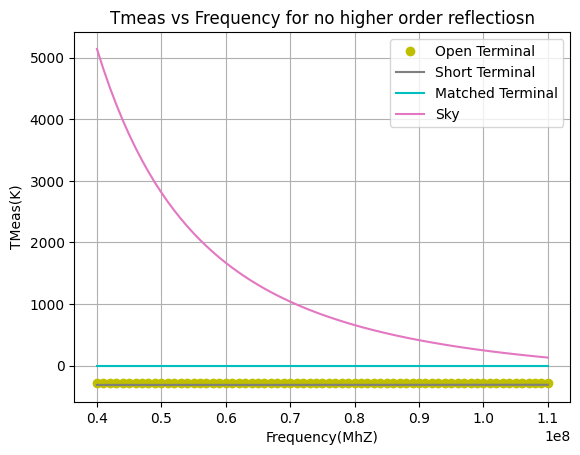

In [14]:
X=[Compute_Tmeas("open",freq=p)for p in v]
Y=[Compute_Tmeas("short",freq=p)for p in v]
Z=[Compute_Tmeas("matched",freq=p)for p in v]
S=[Compute_Tmeas("sky",freq=p)for p in v]
plt.plot(v,X,'oy')
plt.plot(v,Y,'tab:grey')
plt.plot(v,Z,'c')
plt.plot(v,S,'tab:pink')
plt.title("Tmeas vs Frequency for no higher order reflectiosn")
plt.legend(["Open Terminal","Short Terminal","Matched Terminal","Sky"]) 
plt.xlabel("Frequency(MhZ)")
plt.ylabel("TMeas(K)")
plt.grid()

# Estimating the no. of refelctions after which Tmeas saturates by a difference of 1mK

In [25]:
median = st.median(v) #at the median frequency
m=0
while True:
    Tmeas_1= Compute_Tmeas_('sky',median,m)
    Tmeas_2= Compute_Tmeas_('sky',median,m+1)
    if abs(Tmeas_1-Tmeas_2)<=0.001:
        break
    else:
        m=m+1
print(abs(Tmeas_1-Tmeas_2),m)  


0.0009043357615610148 7


# Misc

In [8]:
"""
#computing Tmeas for higher order reflections for sky 
def Compute_Tmeas_sky(itr):
    A=0
    B=0
    C=0
    Tmeas=np.zeros(len(v))
    for i in range(len(v)):
        
        A=sum((abs(gamma_Asky[i])**k)*(abs(gamma_N)**k)*sum(math.cos((2*l-k)*(phi_N+phi_Asky[i]+phi_s[i]))for l in range(k)) for k in range(itr))   
        
        B=sum(2*abs(f)*(abs(gamma_Asky[i])**(a+1))*(abs(gamma_N)**a)*math.cos(phi_f+(a+1)*(phi_Asky[i]+phi_s[i])+a*phi_N) for a in range(itr))
    
        C=sum((abs(gamma_Asky[i])**b)*(abs(gamma_N)**b)*sum(math.cos((2*c-b)*(phi_N+phi_Asky[i]+phi_s[i])) for c in range(b)) for b in range(itr))
    
        Tmeas[i]=((P_sky[i]*A-P_ref)+P_N*(B+(abs(f)**2)*(abs(gamma_Asky[i])**2)*C))
    return(Tmeas)

"""

'\n#computing Tmeas for higher order reflections for sky \ndef Compute_Tmeas_sky(itr):\n    A=0\n    B=0\n    C=0\n    Tmeas=np.zeros(len(v))\n    for i in range(len(v)):\n        \n        A=sum((abs(gamma_Asky[i])**k)*(abs(gamma_N)**k)*sum(math.cos((2*l-k)*(phi_N+phi_Asky[i]+phi_s[i]))for l in range(k)) for k in range(itr))   \n        \n        B=sum(2*abs(f)*(abs(gamma_Asky[i])**(a+1))*(abs(gamma_N)**a)*math.cos(phi_f+(a+1)*(phi_Asky[i]+phi_s[i])+a*phi_N) for a in range(itr))\n    \n        C=sum((abs(gamma_Asky[i])**b)*(abs(gamma_N)**b)*sum(math.cos((2*c-b)*(phi_N+phi_Asky[i]+phi_s[i])) for c in range(b)) for b in range(itr))\n    \n        Tmeas[i]=((P_sky[i]*A-P_ref)+P_N*(B+(abs(f)**2)*(abs(gamma_Asky[i])**2)*C))\n    return(Tmeas)\n\n'

In [ ]:
"""
#computing Tmeas for higher order reflections for sky
def Compute_Tmeas_sky__(itr,freq):
    A=0
    B=0
    C=0

    P_sky= Po*(freq/vo)**-a 
    phi_s= (4*math.pi*(freq)*lmin)/(0.7*c)
    i=v.index(freq)
    gamma_Asky= np.real(d[i][1])
    phi_Asky= np.imag(d[i][1])
    Tmeas=0
        
    A=sum((abs(gamma_Asky)**k)*(abs(gamma_N)**k)*sum(math.cos((2*l-k)*(phi_N+phi_Asky+phi_s))for l in range(k+1)) for k in range(itr))   
    
    B=sum(2*abs(f)*(abs(gamma_Asky)**(o+1))*(abs(gamma_N)**o)*math.cos(phi_f+(o+1)*(phi_Asky+phi_s)+o*phi_N) for o in range(itr))

    C=sum((abs(gamma_Asky)**b)*(abs(gamma_N)**b)*sum(math.cos((2*c-b)*(phi_N+phi_Asky+phi_s)) for c in range(b+1)) for b in range(itr))

    Tmeas=((P_sky*A-P_ref)+P_N*(B+(abs(f)**2)*(abs(gamma_Asky)**2)*C))
    return(Tmeas)
"""

In [ ]:
"""
#computing Tmeas for higher order reflections for sky
def Compute_Tmeas_sky__(itr,freq):
    A=0
    B=0
    C=0

    P_sky= Po*(freq/vo)**-a 
    phi_s= (4*math.pi*(freq)*lmin)/(0.7*c)
    i=v.index(freq)
    gamma_Asky= np.real(d[i][1])
    phi_Asky= np.imag(d[i][1])
    Tmeas=0
        
    A=sum((abs(gamma_Asky)**k)*(abs(gamma_N)**k)*sum(math.cos((2*l-k)*(phi_N+phi_Asky+phi_s))for l in range(k+1)) for k in range(itr))   
    
    B=sum(2*abs(f)*(abs(gamma_Asky)**(o+1))*(abs(gamma_N)**o)*math.cos(phi_f+(o+1)*(phi_Asky+phi_s)+o*phi_N) for o in range(itr))

    C=sum((abs(gamma_Asky)**b)*(abs(gamma_N)**b)*sum(math.cos((2*c-b)*(phi_N+phi_Asky+phi_s)) for c in range(b+1)) for b in range(itr))

    Tmeas=((P_sky*A-P_ref)+P_N*(B+(abs(f)**2)*(abs(gamma_Asky)**2)*C))
    return(Tmeas)
"""